In [1]:
import requests
import copy
from music21 import *
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# Download files - don't use this code to scrape unless put in a timer to pause between downloads

# for i in range(1,25):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkI/{}'.format(file_name)
#     r = requests.get(url)

#     with open(file_name, 'wb') as f:
#         f.write(chunk)

# for i in range(1,13):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkIIx/{}'.format(file_name)
#     r = requests.get(url)
#     file_name = 'Fugue{}_wtcii.mid'.format(i)
#     with open(file_name, 'wb') as f:
#         f.write(chunk)

In [2]:
def clean_zero_durations(midi_data):
    for stream in range(len(midi_data)):
        for element in range(len(midi_data[stream])):
            current_element = midi_data[stream][element]
            if isinstance(current_element, note.Note) or isinstance(current_element, chord.Chord) or isinstance(current_element, note.Rest):
                if current_element.duration.quarterLength == 0:
                    midi_data[stream][element].quarterLength = 0.125
    return midi_data

def print_zero_midi_data(midi_data):
    for stream in range(len(midi)):
        for element in range(len(midi[stream])):
            current_element = midi[stream][element]
            if current_element.duration.quarterLength == 0:
                print(midi[stream][element].quarterLength, current_element)

def print_midi_data(midi_data):
    for stream in range(len(midi_data)):
        current_stream = midi_data[stream].notesAndRests
        for element in range(len(current_stream)):
            current_element = current_stream[element]
            print(current_element.duration.type, current_element, current_element.duration.quarterLength)

In [30]:
def get_notes(midi_data, begin=False, end=False):
    
    if begin:
        features = ['begin']
    else:
        features = []
        
    midi_data = midi_data.chordify()
    for element in midi_data.notesAndRests:
        if isinstance(element, note.Rest):
            features.append('{}%{}'.format(element.duration.quarterLength, element.name))
        elif isinstance(element, note.Note):
            features.append('{}%{}'.format(element.duration.quarterLength, element.namewithOctave))                        
## alternative code for chords with ties counted as individual notes ###
        elif isinstance(element, chord.Chord):
            current_chord = [str(element.duration.quarterLength)]
            for pitch in element.pitches:
                current_chord.append(pitch.nameWithOctave)
            features.append('%'.join(current_chord))

            
    if end:
        features.append('end')
        
    return features

In [31]:
def load_data():
    notes_data = []
    cwd = os.getcwd() + '/midi_files'
    for path in Path(cwd).glob('**/*.mid'):
        # because path is object not string
        file = str(path)
        try:
            midi = converter.parse(file)
            midi = clean_zero_durations(midi)
            notes = get_notes(midi, False, False)
            notes_data.extend(notes)
        except:
            print(file)
    return notes_data

In [32]:
notes_data = load_data()

/home/ubuntu/midi_files/fugue12.mid
/home/ubuntu/midi_files/fugue19.mid
/home/ubuntu/midi_files/fugue6.mid


In [33]:
## https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
len(notes_data)

21390

In [34]:
df = pd.DataFrame(notes_data)
df.columns = ['notes']
df['count'] = df.groupby('notes')['notes'].transform('count')

Text(0.5,1,'Histogram of number of times a note combination appears')

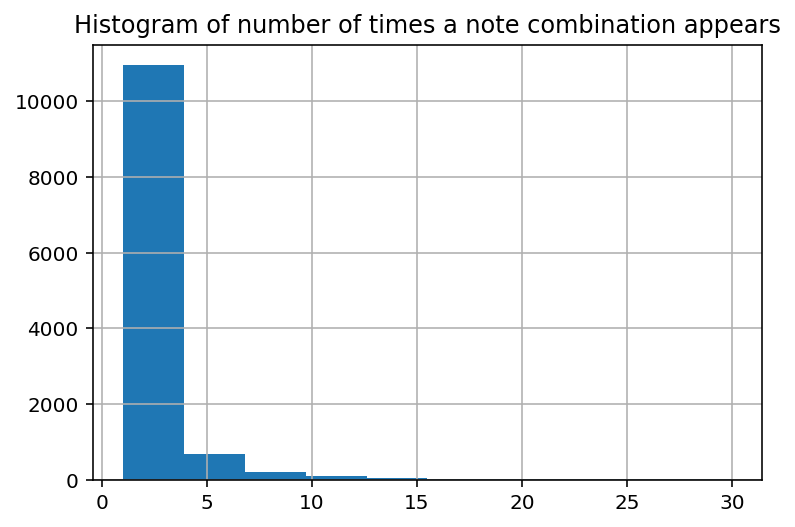

In [35]:
df.drop_duplicates()['count'].hist()
plt.title('Histogram of number of times a note combination appears')

In [36]:
# create mapping of unique chars to integers
chars = sorted(list(set(notes_data)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [37]:
n_chars = len(notes_data)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  21390
Total Vocab:  11994


In [44]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 25
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = notes_data[i:i + seq_length]
    seq_out = notes_data[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  21365


In [45]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [46]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [47]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [67]:
model.fit(X, y, epochs=50, batch_size=32, callbacks=callbacks_list)

Epoch 1/50
21365/21365 [==============================] - 40s 2ms/step - loss: 1.2355

Epoch 00001: loss improved from 1.31738 to 1.23547, saving model to weights-improvement-01-1.2355.hdf5
Epoch 2/50
21365/21365 [==============================] - 41s 2ms/step - loss: 1.1507

Epoch 00002: loss improved from 1.23547 to 1.15073, saving model to weights-improvement-02-1.1507.hdf5
Epoch 3/50
21365/21365 [==============================] - 40s 2ms/step - loss: 1.0844

Epoch 00003: loss improved from 1.15073 to 1.08441, saving model to weights-improvement-03-1.0844.hdf5
Epoch 4/50
21365/21365 [==============================] - 41s 2ms/step - loss: 1.0227

Epoch 00004: loss improved from 1.08441 to 1.02274, saving model to weights-improvement-04-1.0227.hdf5
Epoch 5/50
21365/21365 [==============================] - 40s 2ms/step - loss: 0.9643

Epoch 00005: loss improved from 1.02274 to 0.96426, saving model to weights-improvement-05-0.9643.hdf5
Epoch 6/50
21365/21365 [==========================

KeyboardInterrupt: 

In [22]:
# load the network weights
# filename = "weights-improvement-15-5.7794.hdf5"
# model.load_weights(filename)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

In [68]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [69]:
note_sequence = []

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    note_sequence.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 0.5%G4%B40.5%A4%C50.25%E-4%B40.25%E-4%A40.25%B3%G40.25%B3%A40.5%B40.5%E4%C50.25%F#4%C50.25%G4%C50.25%E4%B40.25%F#4%A40.25%G4%B40.25%A4%B40.25%F#4%E50.25%G4%E50.5%A4%E50.25%G4%D50.25%G4%C#50.5%F#4%D50.5%B4%D50.5%E4%D50.25%F#4%C50.25%G#4%B40.25%A4%C5 "

Done.


In [70]:
note_sequence

['0.25%B4%C5',
 '0.25%B-2%F#4%E-5',
 '0.25%C5%D5',
 '0.25%C5%E5',
 '0.25%E5%A5',
 '0.25%A4%G5',
 '0.5%D5',
 '0.25%G#4%E5',
 '0.25%G#4%D5',
 '0.25%G#4%C5',
 '0.5%A4',
 '0.25%E-4%A4',
 '0.25%A4%C5',
 '0.25%A4%C5',
 '0.25%F#4%B4%E-5',
 '0.25%F#4%B4%E-5',
 '0.25%E-3%C5%B-5',
 '0.25%C3%E-5',
 '0.25%G3%G#4%B-4',
 '0.25%G2%C5',
 '0.25%G3%F4',
 '0.25%G3%E-4',
 '0.25%E-4%F#4%C5',
 '0.25%C#4%E-5%F5',
 '1/12%A3%C#4%G4%D5',
 '0.25%B-3%E-4%E-5',
 '0.25%F3%D5%G#5',
 '0.25%C#4%E-4%E-5',
 '0.25%D3%F4',
 '0.25%D3%G4%F#5',
 '0.25%F3%B-4%C#5',
 '0.25%A4%C5',
 '0.25%B-2%E-4',
 '0.25%G3%G4',
 '0.25%D4%B-4',
 '0.25%A2%G3%E-5',
 '0.25%E-2%G4',
 '0.25%G2%A4%C#5',
 '0.25%C3%G3%C4%D4',
 '0.25%G3%D5',
 '0.25%C4%A5',
 '0.25%G3%E-4%C#5',
 '0.5%G4%B4%G5',
 '0.5%F4%A4%G5',
 '0.25%A3%C#4%E4',
 '0.25%A3%C#4%E4',
 '0.25%B-3%E-5',
 '0.25%B-3%B-4',
 '0.25%B3%G4%G5',
 '0.25%G3%E-5',
 '0.25%G3%E-4%G5',
 '0.25%F3%E4%C5',
 '0.25%D3%F4%C5',
 '0.125%A4%G5',
 '0.25%F3%D4',
 '0.25%C#3%A4%E5',
 '0.25%F4%A4%D5',
 '0.5%D3%C4%A4',
 

In [71]:
def from_string_to_music(note_sequence):
    midi_stream = stream.Stream()
    for entry in note_sequence:
        if entry == 'begin' or entry == 'end':
            continue

        current_notes = entry.split('%')
        duration = float(eval(current_notes[0]))

        if current_notes[1] == 'rest':
            midi_stream.append(note.Rest(quarterLength=duration))
        else:
            chord_notes = []
            for entry in current_notes[1:]:
                chord_notes.append(note.Note(quarterLength=duration, nameWithOctave=entry))
            midi_stream.append(chord.Chord(chord_notes))

    midi_stream.write('midi', fp='test_output_constant_time.mid')
    return midi_stream

In [72]:
midi_stream = from_string_to_music(note_sequence)

for entry in midi_stream.notesAndRests:
    print(entry)

<music21.chord.Chord B4 C5>
<music21.chord.Chord B-2 F#4 E-5>
<music21.chord.Chord C5 D5>
<music21.chord.Chord C5 E5>
<music21.chord.Chord E5 A5>
<music21.chord.Chord A4 G5>
<music21.chord.Chord D5>
<music21.chord.Chord G#4 E5>
<music21.chord.Chord G#4 D5>
<music21.chord.Chord G#4 C5>
<music21.chord.Chord A4>
<music21.chord.Chord E-4 A4>
<music21.chord.Chord A4 C5>
<music21.chord.Chord A4 C5>
<music21.chord.Chord F#4 B4 E-5>
<music21.chord.Chord F#4 B4 E-5>
<music21.chord.Chord E-3 C5 B-5>
<music21.chord.Chord C3 E-5>
<music21.chord.Chord G3 G#4 B-4>
<music21.chord.Chord G2 C5>
<music21.chord.Chord G3 F4>
<music21.chord.Chord G3 E-4>
<music21.chord.Chord E-4 F#4 C5>
<music21.chord.Chord C#4 E-5 F5>
<music21.chord.Chord A3 C#4 G4 D5>
<music21.chord.Chord B-3 E-4 E-5>
<music21.chord.Chord F3 D5 G#5>
<music21.chord.Chord C#4 E-4 E-5>
<music21.chord.Chord D3 F4>
<music21.chord.Chord D3 G4 F#5>
<music21.chord.Chord F3 B-4 C#5>
<music21.chord.Chord A4 C5>
<music21.chord.Chord B-2 E-4>
<music